In [39]:
# Benchmark Datasets
from benchmark import Benchmark

datasets = Benchmark.load_all_benchmark_datasets()

df = datasets["ecoli"] # datasets["ecoli"]

In [40]:
# HTRU2 Dataset

# import pandas as pd

# column_names = ["ip_mean", "ip_std", "ip_excess_curtosis", "ip_skewness", "dmsnr_mean", "dmsnr_std", "dmsnr_excess_curtosis", "dmsnr_skewness", "target"]
# df = pd.read_csv("../data/HTRU2/HTRU_2.csv", header=None, names=column_names)

In [41]:
# Standardize Dataset
from preprocessing import standardize

df = standardize(df)

In [42]:
# Set our RNG seed for reproducibility.
import numpy as np
from config import RANDOM_STATE_SEED
np.random.seed(RANDOM_STATE_SEED)

In [43]:
X_raw = df.loc[:, df.columns != 'target']#.to_numpy()
y_raw = df['target']#.to_numpy()

In [44]:
# PCA decomposition
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_df = pca.fit_transform(X=X_raw)

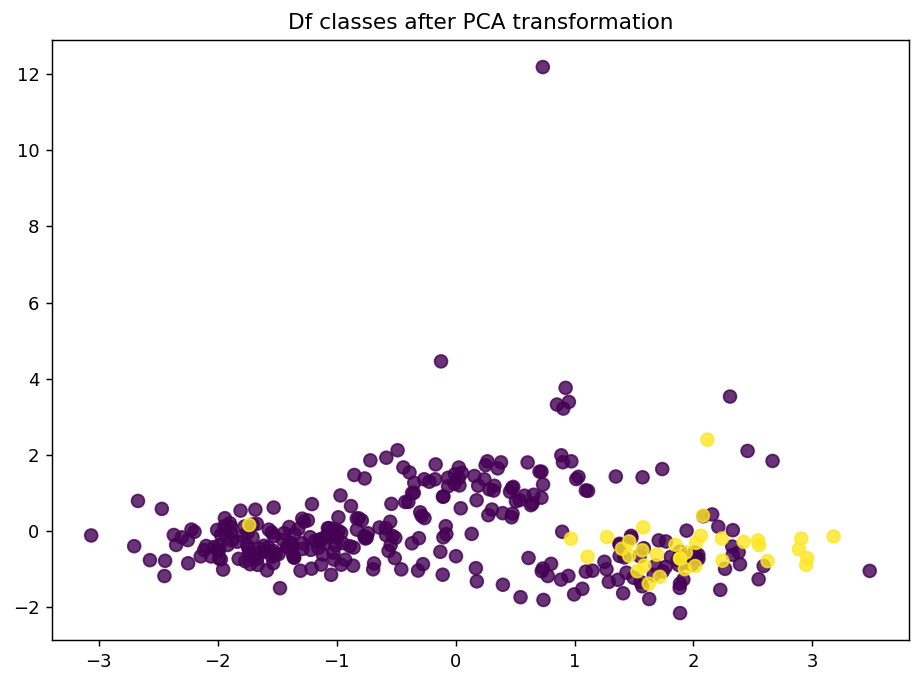

In [45]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_df[:, 0], transformed_df[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Df classes after PCA transformation')
plt.show()

In [46]:
# Samples weighting & Hyperparameters tunning
from config import WEIGHTED_TRAINING, HYPERPARAMETERS_TUNNING

# Samples weighting
from sklearn.utils.class_weight import compute_class_weight

def get_class_weight(y_train_init):
    if WEIGHTED_TRAINING:
        classes_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_init), y=y_train_init)
        CLASS_WEIGHT = {}
        for c, cw in list(zip(np.unique(y_train_init), classes_weights)):
            CLASS_WEIGHT[c] = cw
        print(CLASS_WEIGHT)
    else:
        CLASS_WEIGHT = None
    return CLASS_WEIGHT

# Hyperparameters tunning
from sklearn.base import ClassifierMixin
from sklearn.model_selection._search import  BaseSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, GridSearchCV, HalvingGridSearchCV
from sklearn.utils.class_weight import compute_sample_weight

def tune_classifiers_hyperparameters_cw(Clf: ClassifierMixin, X, y, params_grid, GridSearchMethod: BaseSearchCV,  scorer, class_weight=None, random_state=13, verbose=True) -> tuple:

    skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
    # Any GridSearch assumes stratified folds if there is classifier
    if issubclass(GridSearchMethod, GridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=params_grid, scoring=scorer, refit=True, cv=skf)
    elif issubclass(GridSearchMethod, HalvingGridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=params_grid, scoring=scorer, refit=True, cv=skf, factor=2)
    else:
        raise ValueError("Unknown or unsupported BaseSearchCV") 

    if class_weight:
        sample_weight = compute_sample_weight(class_weight=class_weight, y=y)
    else:
        sample_weight = None
    gs.fit(X, y, sample_weight=sample_weight)

    if verbose:
        params_combinations = gs.cv_results_["params"]
        params_combinations_scores = gs.cv_results_["mean_test_score"]
        for i, params in enumerate(params_combinations):
            print(f"{params}\n{params_combinations_scores[i]}")

    return (gs.best_estimator_, gs.best_params_)

In [47]:
# Query and batch size
import warnings
from config import StoppingCriterion, BatchMode, AL_N_QUERIES, AL_QUERY_FIXED_BATCH_SIZE, AL_FRACTION_OF_TRAIN_QUERIES, AL_QUERY_FRACTION_OF_TRAIN_BATCH_SIZE
def perpare_queries_and_batch_size(stopping_criterion: StoppingCriterion, batch_mode: BatchMode, pool_size: int, init_train_size: int) -> tuple:
    match stopping_criterion.name:
        case "N_QUERIES":
            n_queries = AL_N_QUERIES
            match batch_mode.name:
                case 'FIXED_BATCH_SIZE':
                    batch_size = AL_QUERY_FIXED_BATCH_SIZE
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
                case 'FRACTION_OF_N_QUERIES':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.") # TODO?
                case 'FRACTION_OF_TRAIN_SIZE':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.") # TODO?
        case "FRACTION_OF_TRAIN_QUERIES":
            n_queries = int((AL_FRACTION_OF_TRAIN_QUERIES * pool_size / 0.9) - init_train_size)
            match batch_mode.name:
                case 'FIXED_BATCH_SIZE':
                    batch_size = AL_QUERY_FIXED_BATCH_SIZE
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
                case 'FRACTION_OF_N_QUERIES':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.")
                case 'FRACTION_OF_TRAIN_SIZE':
                    batch_size = int(AL_QUERY_FRACTION_OF_TRAIN_BATCH_SIZE * pool_size / 0.9)
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
        # TODO: Add debuging of number of queries

        case "ENTROPY_CONFIDENCE":
            n_queries = pool_size
            batch_size = AL_QUERY_FIXED_BATCH_SIZE
            if n_queries * batch_size > pool_size:
                        n_queries = int(n_queries/batch_size)
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
            n_decline_rounds = 0

    if n_queries > pool_size:
        n_queries = pool_size
            

    return n_queries, batch_size

In [48]:
import warnings, copy, time, functools
from collections import Counter
import pandas as pd

from config import TEST_SIZE, INITIAL_TRAIN_SIZE, WEIGHTED_TRAINING, VERBOSE, PARAMS_GRID
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from metrics import method_eval, f2_score

from modAL import ActiveLearner
from modAL.random_sampling import random_sampling
from modAL.uncertainty import uncertainty_sampling
from modAL.expected_error import expected_error_reduction
from modAL.uncertainty import classifier_entropy
from modAL.utils.data import data_vstack


def expected_error_reduction_with_loss(func, loss_type: str):
    @functools.wraps(func)
    def loss_wrapper(*args, **kwargs):
        return func(*args, loss=loss_type, **kwargs)
    return loss_wrapper

expected_log_error_reduction = expected_error_reduction_with_loss(expected_error_reduction, loss_type="log")

def al_cv(X_raw: pd.DataFrame, y_raw: pd.DataFrame, Clf = GaussianNB, query_strategy = expected_error_reduction, query_strategy_parameters={}):
    results = {"folds": []}

    # Stratified K-Folds cross-validator
    skf = StratifiedKFold(n_splits=int(1/TEST_SIZE), random_state=RANDOM_STATE_SEED, shuffle=True) 
    for k, (kf_train_indices, kf_test_indices) in enumerate(skf.split(X_raw, y_raw)):

        fold_results = {}

        if VERBOSE:
            print(50*'*')
            print(f"Fold no.{k+1}")
            print(50*'*')

        # K-Fold train and test
        X_train, X_test, y_train, y_test = X_raw.iloc[kf_train_indices], \
        X_raw.iloc[kf_test_indices], y_raw.iloc[kf_train_indices], y_raw.iloc[kf_test_indices]
        
        # K-Fold pool from train
        X_train_init, X_pool, y_train_init, y_pool = train_test_split(X_train, y_train, \
                                                        train_size=INITIAL_TRAIN_SIZE, stratify=y_train, random_state=RANDOM_STATE_SEED)
        
        # Hyperparameters tunning
        if HYPERPARAMETERS_TUNNING:
            _, params = tune_classifiers_hyperparameters_cw(Clf, X_train_init, y_train_init, params_grid=PARAMS_GRID[Clf.__name__], GridSearchMethod=GridSearchCV, scorer=f2_score, class_weight=class_weight, random_state=RANDOM_STATE_SEED, verbose=VERBOSE)
        else:
            params = {}

        # Samples weighting for AL
        sample_weight = None
        if WEIGHTED_TRAINING:
            class_weight = get_class_weight(y_train_init)
            sample_weight = compute_sample_weight(class_weight=class_weight, y=y_train_init)
            learner = ActiveLearner(estimator=Clf(**params), X_training=X_train_init, y_training=y_train_init, query_strategy=query_strategy, sample_weight=sample_weight)
        else:
            learner = ActiveLearner(estimator=Clf(**params), X_training=X_train_init, y_training=y_train_init, query_strategy=query_strategy) # TODO: Refactor to map factory

        model = Clf(**params)

        # Samples weighting for full model
        if WEIGHTED_TRAINING:
            sample_weight = compute_sample_weight(class_weight=class_weight, y=y_train)
            model.fit(X_train, y_train, sample_weight=sample_weight)
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        print("Full dataset model")
        print(50*'-')
        full_model_score = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
        print(50*'-')

        fold_results["full_model"] = full_model_score

        # Evaluate initial model
        y_pred = learner.predict(X_test)
        y_proba = learner.predict_proba(X_test)

        print("Initial model")
        print(50*'-')
        unqueried_score = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
        print(50*'-')

        fold_results["initial_model"] = unqueried_score

        
        learner_al = copy.deepcopy(learner)
        X_pool_al, y_pool_al = copy.deepcopy(X_pool), copy.deepcopy(y_pool)

        warnings.simplefilter(action='ignore', category=FutureWarning)

        from config import StoppingCriterion, BatchMode, AL_N_DECLINE_ROUNDS
        stopping_criterion  = StoppingCriterion.FRACTION_OF_TRAIN_QUERIES
        batch_mode = BatchMode.FIXED_BATCH_SIZE
        n_queries, batch_size = perpare_queries_and_batch_size(stopping_criterion, batch_mode, len(y_pool_al), len(learner.y_training))

        # AL statistics
        queried_classes_counter = Counter()
        performance_history = [unqueried_score["metrics"]]
        iterations_time_history = []
        initial_confidence = np.mean(classifier_entropy(learner_al, X_test))
        entropy_confidence_history = [initial_confidence]

        if VERBOSE:
            print(50*'=')
            print(f"Active Learning")
            print(50*'=')

        # Allow our model to query unlabeled dataset for the most
        # informative points according to our query strategy (uncertainty sampling).
        for index in range(n_queries):
            if index == 240: # ?Bad sample?
                pass

            start = time.perf_counter()
            query_index, query_instance = learner_al.query(X_pool_al.to_numpy(), **query_strategy_parameters, n_instances=batch_size)

            # To track which samples are choosen. It is usefull, when comparing different algorithms.
            global_query_index = X_pool_al.iloc[query_index].index

            print(f"\n{index+1}. iteration: \nChosen sample was of an index: {global_query_index[-1]}\nChosen sample was of a class: {y_pool_al.iloc[query_index]}\n")
            queried_classes_counter.update(y_pool_al.iloc[query_index])

            # Teach our ActiveLearner model the record it has requested.
            X, y = X_pool_al.iloc[query_index], y_pool_al.iloc[query_index]
            if WEIGHTED_TRAINING:
                new_y = data_vstack((learner_al.y_training, y))
                sample_weight = compute_sample_weight(class_weight=class_weight, y=new_y)
                learner_al.teach(X=X.to_numpy(), y=y.to_numpy(), sample_weight=sample_weight)
            else:
                learner_al.teach(X=X.to_numpy(), y=y.to_numpy())
                # learner_al.teach(X=X, y=y, sample_weight=sample_weight, bootstrap=True, stratify=True) # for Query-By-Bagging


            # Remove the queried instance from the unlabeled pool.
            X_pool_al, y_pool_al = X_pool_al.drop(global_query_index), y_pool_al.drop(global_query_index)

            # Calculate and report our model's accuracy.
            y_pred = learner_al.predict(X_test)
            y_proba = learner_al.predict_proba(X_test)
            print(50*'-')
            model_evaluation = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
            print(50*'-')

            # Save our model's performance for plotting.
            performance_history.append(model_evaluation["metrics"])

            # Entropy confidence
            entropy_confidence_history.append(np.mean(classifier_entropy(learner_al, X_test)))
            if stopping_criterion == "ENTROPY_CONFIDENCE":
                if entropy_confidence_history[-1] < entropy_confidence_history[-2]:
                    n_decline_rounds += 1
                else:
                    n_decline_rounds = 0
                if n_decline_rounds >= AL_N_DECLINE_ROUNDS:
                    break
                if len(y_pool_al) < batch_size:
                    break
            
            elapsed = time.perf_counter() - start
            iterations_time_history.append(elapsed)
    
        print(f"Queried samples:\n {queried_classes_counter}")
        n_queries = sum(queried_classes_counter.values())
        print(f"{len(y_train_init) + n_queries} out of {len(y_train)} samples seen.")
        print(f"Average iteration time was {np.mean(iterations_time_history):0.2f}s")

        fold_results["al_final_model"] = {"metrics": performance_history[-1]}
        fold_results["al_metrics"] = performance_history
        fold_results["al_confidence"] = entropy_confidence_history
        fold_results["al_queries"] = queried_classes_counter
        fold_results["avg_time_of_query"] = np.mean(iterations_time_history)
        results["folds"].append(fold_results)

    return results

Clf = GaussianNB

rs_results = al_cv(X_raw, y_raw, Clf=Clf, query_strategy=random_sampling)
us_results = al_cv(X_raw, y_raw, Clf=Clf, query_strategy=uncertainty_sampling)
eer_results = al_cv(X_raw, y_raw, Clf=Clf, query_strategy=expected_log_error_reduction, query_strategy_parameters={'pool_candidates_size': 200})


**************************************************
Fold no.1
**************************************************
Full dataset model
--------------------------------------------------
accuracy: 0.6911764705882353,
precision: 0.25,
recall: 1.0,
f2_score: 0.625,
auc_pr_curve: 0.5766156462585034,
auc_roc_curve: 0.9672131147540983
--------------------------------------------------
Initial model
--------------------------------------------------
accuracy: 0.9117647058823529,
precision: 0.5454545454545454,
recall: 0.8571428571428571,
f2_score: 0.7692307692307693,
auc_pr_curve: 0.43618985296726154,
auc_roc_curve: 0.8782201405152225
--------------------------------------------------
Active Learning

1. iteration: 
Chosen sample was of an index: 103
Chosen sample was of a class: 103   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9117647058823529,
precision: 0.5454545454545454,
recall: 0.8571428571428571,
f2_score: 0.7692307692307693,
auc_pr_curve: 

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")


--------------------------------------------------
accuracy: 0.835820895522388,
precision: 0.375,
recall: 0.8571428571428571,
f2_score: 0.6818181818181818,
auc_pr_curve: 0.6174291090335866,
auc_roc_curve: 0.8178571428571428
--------------------------------------------------

8. iteration: 
Chosen sample was of an index: 163
Chosen sample was of a class: 163   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.835820895522388,
precision: 0.375,
recall: 0.8571428571428571,
f2_score: 0.6818181818181818,
auc_pr_curve: 0.6174291090335866,
auc_roc_curve: 0.8178571428571428
--------------------------------------------------

9. iteration: 
Chosen sample was of an index: 216
Chosen sample was of a class: 216   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.835820895522388,
precision: 0.375,
recall: 0.8571428571428571,
f2_score: 0.6818181818181818,
auc_pr_curve: 0.6174291090335866,
auc_roc_curve: 0.8178571

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")


accuracy: 0.9552238805970149,
precision: 1.0,
recall: 0.5714285714285714,
f2_score: 0.625,
auc_pr_curve: 0.6393717001726064,
auc_roc_curve: 0.7523809523809524
--------------------------------------------------

8. iteration: 
Chosen sample was of an index: 120
Chosen sample was of a class: 120   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9552238805970149,
precision: 1.0,
recall: 0.5714285714285714,
f2_score: 0.625,
auc_pr_curve: 0.6393717001726064,
auc_roc_curve: 0.7523809523809524
--------------------------------------------------

9. iteration: 
Chosen sample was of an index: 158
Chosen sample was of a class: 158   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9552238805970149,
precision: 1.0,
recall: 0.5714285714285714,
f2_score: 0.625,
auc_pr_curve: 0.6393717001726064,
auc_roc_curve: 0.7523809523809524
--------------------------------------------------

10. iteration: 
Chosen sample w

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")


accuracy: 0.9104477611940298,
precision: 1.0,
recall: 0.14285714285714285,
f2_score: 0.17241379310344823,
auc_pr_curve: 0.7983100233100231,
auc_roc_curve: 0.9666666666666667
--------------------------------------------------

5. iteration: 
Chosen sample was of an index: 322
Chosen sample was of a class: 322   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9104477611940298,
precision: 1.0,
recall: 0.14285714285714285,
f2_score: 0.17241379310344823,
auc_pr_curve: 0.7802828124256695,
auc_roc_curve: 0.9642857142857143
--------------------------------------------------

6. iteration: 
Chosen sample was of an index: 197
Chosen sample was of a class: 197   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9104477611940298,
precision: 1.0,
recall: 0.14285714285714285,
f2_score: 0.17241379310344823,
auc_pr_curve: 0.7983100233100231,
auc_roc_curve: 0.9666666666666667
--------------------------------------

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")


accuracy: 0.8955223880597015,
precision: 0.5,
recall: 0.42857142857142855,
f2_score: 0.44117647058823534,
auc_pr_curve: 0.4879721279227358,
auc_roc_curve: 0.8452380952380952
--------------------------------------------------

15. iteration: 
Chosen sample was of an index: 203
Chosen sample was of a class: 203   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.5,
recall: 0.42857142857142855,
f2_score: 0.44117647058823534,
auc_pr_curve: 0.4879721279227358,
auc_roc_curve: 0.8452380952380952
--------------------------------------------------

16. iteration: 
Chosen sample was of an index: 105
Chosen sample was of a class: 105   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.5,
recall: 0.42857142857142855,
f2_score: 0.44117647058823534,
auc_pr_curve: 0.4879721279227358,
auc_roc_curve: 0.8452380952380952
------------------------------------

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")


accuracy: 0.7313432835820896,
precision: 0.2608695652173913,
recall: 0.8571428571428571,
f2_score: 0.5882352941176471,
auc_pr_curve: 0.4831732854920488,
auc_roc_curve: 0.8035714285714286
--------------------------------------------------

14. iteration: 
Chosen sample was of an index: 46
Chosen sample was of a class: 46   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7313432835820896,
precision: 0.2608695652173913,
recall: 0.8571428571428571,
f2_score: 0.5882352941176471,
auc_pr_curve: 0.4831732854920488,
auc_roc_curve: 0.8035714285714286
--------------------------------------------------

15. iteration: 
Chosen sample was of an index: 147
Chosen sample was of a class: 147   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7313432835820896,
precision: 0.2608695652173913,
recall: 0.8571428571428571,
f2_score: 0.5882352941176471,
auc_pr_curve: 0.4831732854920488,
auc_roc_curve: 0.8035714285714286

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")


accuracy: 0.8955223880597015,
precision: 0.5,
recall: 0.5714285714285714,
f2_score: 0.5555555555555556,
auc_pr_curve: 0.5762897755959735,
auc_roc_curve: 0.7095238095238096
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 194
Chosen sample was of a class: 194   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.5,
recall: 0.5714285714285714,
f2_score: 0.5555555555555556,
auc_pr_curve: 0.5752641345703324,
auc_roc_curve: 0.7071428571428572
--------------------------------------------------

4. iteration: 
Chosen sample was of an index: 241
Chosen sample was of a class: 241    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8805970149253731,
precision: 0.45454545454545453,
recall: 0.7142857142857143,
f2_score: 0.641025641025641,
auc_pr_curve: 0.48851822780394205,
auc_roc_curve: 0.8690476190476191
----------------------------

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")


accuracy: 0.8955223880597015,
precision: 0.5,
recall: 1.0,
f2_score: 0.8333333333333334,
auc_pr_curve: 0.8184987631416201,
auc_roc_curve: 0.9761904761904762
--------------------------------------------------

12. iteration: 
Chosen sample was of an index: 167
Chosen sample was of a class: 167   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.5,
recall: 1.0,
f2_score: 0.8333333333333334,
auc_pr_curve: 0.8184987631416201,
auc_roc_curve: 0.9761904761904762
--------------------------------------------------

13. iteration: 
Chosen sample was of an index: 196
Chosen sample was of a class: 196   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.5,
recall: 1.0,
f2_score: 0.8333333333333334,
auc_pr_curve: 0.8184987631416201,
auc_roc_curve: 0.9761904761904762
--------------------------------------------------

14. iteration: 
Chosen sample was o

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")


accuracy: 0.8805970149253731,
precision: 0.4444444444444444,
recall: 0.5714285714285714,
f2_score: 0.5405405405405406,
auc_pr_curve: 0.6042968935826079,
auc_roc_curve: 0.930952380952381
--------------------------------------------------

14. iteration: 
Chosen sample was of an index: 256
Chosen sample was of a class: 256    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8805970149253731,
precision: 0.46153846153846156,
recall: 0.8571428571428571,
f2_score: 0.7317073170731707,
auc_pr_curve: 0.7937508919651777,
auc_roc_curve: 0.9619047619047618
--------------------------------------------------

15. iteration: 
Chosen sample was of an index: 193
Chosen sample was of a class: 193   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8805970149253731,
precision: 0.46153846153846156,
recall: 0.8571428571428571,
f2_score: 0.7317073170731707,
auc_pr_curve: 0.7937508919651777,
auc_roc_curve: 0.9619047619047

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")



1. iteration: 
Chosen sample was of an index: 253
Chosen sample was of a class: 253    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7313432835820896,
precision: 0.2608695652173913,
recall: 0.8571428571428571,
f2_score: 0.5882352941176471,
auc_pr_curve: 0.48460597978188596,
auc_roc_curve: 0.8035714285714285
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 143
Chosen sample was of a class: 143   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7313432835820896,
precision: 0.2608695652173913,
recall: 0.8571428571428571,
f2_score: 0.5882352941176471,
auc_pr_curve: 0.5066864786480991,
auc_roc_curve: 0.8083333333333332
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 233
Chosen sample was of a class: 233    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7313

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")



1. iteration: 
Chosen sample was of an index: 88
Chosen sample was of a class: 88   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9104477611940298,
precision: 1.0,
recall: 0.14285714285714285,
f2_score: 0.17241379310344823,
auc_pr_curve: 0.6159574186521217,
auc_roc_curve: 0.6547619047619048
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 216
Chosen sample was of a class: 216   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9104477611940298,
precision: 1.0,
recall: 0.14285714285714285,
f2_score: 0.17241379310344823,
auc_pr_curve: 0.6164016164647407,
auc_roc_curve: 0.6571428571428571
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 87
Chosen sample was of a class: 87   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9104477611940298,
precision: 1.0,
r

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")



1. iteration: 
Chosen sample was of an index: 60
Chosen sample was of a class: 60   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.0,
recall: 0.0,
f2_score: 0,
auc_pr_curve: 0.3162901384329956,
auc_roc_curve: 0.8690476190476191
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 198
Chosen sample was of a class: 198   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.0,
recall: 0.0,
f2_score: 0,
auc_pr_curve: 0.3162901384329956,
auc_roc_curve: 0.8690476190476191
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 16
Chosen sample was of a class: 16   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.0,
recall: 0.0,
f2_score: 0,
auc_pr_curve: 0.3162901384329956,
auc_roc_c

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3021617557.py:24: UserWarning: Warning: The pool samples size (243) is to small for requested number of queries (244). Decreasing n_queries to match pool_size.
  warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")



1. iteration: 
Chosen sample was of an index: 177
Chosen sample was of a class: 177   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8805970149253731,
precision: 0.4,
recall: 0.2857142857142857,
f2_score: 0.30303030303030304,
auc_pr_curve: 0.4879721279227358,
auc_roc_curve: 0.8452380952380952
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 106
Chosen sample was of a class: 106   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8805970149253731,
precision: 0.4,
recall: 0.2857142857142857,
f2_score: 0.30303030303030304,
auc_pr_curve: 0.4879721279227358,
auc_roc_curve: 0.8452380952380952
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 14
Chosen sample was of a class: 14   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8805970149253731,
precision: 0.4,
r

In [49]:
original_string = """
'accuracy':  0.9127408922588609
'precision':  0.4821714285714286
'recall':  0.472
'f2_score':  0.4728933699263324
'auc_pr_curve':  0.44137238750740604
'auc_roc_curve':  0.7620817168104355
"""

# Extract numerical values using regular expressions
import re
values = re.findall(r'\d+\.\d+', original_string)

# Format the values as requested
formatted_string = ' & '.join(map(lambda x: f"{float(x):.4f}", values))

print(formatted_string)

0.9127 & 0.4822 & 0.4720 & 0.4729 & 0.4414 & 0.7621


In [50]:
# Metrics averaging
def average_results(results: list) -> dict:
    ## Extracting information from results
    cv_results = {}
    for fold in results["folds"]:
        for k in fold.keys():
            if "model" in k:
                if k in cv_results:
                    for m in cv_results[k].keys():
                        cv_results[k][m] += fold[k]["metrics"][m]
                else:
                    cv_results[k] = fold[k]["metrics"]

    folds_no = len(results["folds"])

    if VERBOSE:
            print(50*'=')
            print(f"Averaged CV results")
            print(50*'=')

    ## Averaging
    for model in cv_results.keys():
        if VERBOSE:
            print(50*'*')
            print(f"{model}")
            print(50*'*')
        for metric in cv_results[model]:
            cv_results[model][metric] /= folds_no
            if VERBOSE:
                print(f"'{metric}': ", cv_results[model][metric])
    return cv_results

average_results(rs_results)
average_results(us_results)
average_results(eer_results)

Averaged CV results
**************************************************
full_model
**************************************************
'accuracy':  0.7352502194907814
'precision':  0.27999999999999997
'recall':  0.9428571428571428
'f2_score':  0.6365740740740741
'auc_pr_curve':  0.5591308654819658
'auc_roc_curve':  0.9027283372365339
**************************************************
initial_model
**************************************************
'accuracy':  0.8868305531167691
'precision':  0.46409090909090905
'recall':  0.42857142857142855
'f2_score':  0.38529860943654043
'auc_pr_curve':  0.4947677294017403
'auc_roc_curve':  0.8130249804839969
**************************************************
al_final_model
**************************************************
'accuracy':  0.7352502194907814
'precision':  0.27999999999999997
'recall':  0.9428571428571428
'f2_score':  0.6365740740740741
'auc_pr_curve':  0.5591308654819658
'auc_roc_curve':  0.9027283372365339
Averaged CV results
*********

{'full_model': {'accuracy': 0.7352502194907814,
  'precision': 0.27999999999999997,
  'recall': 0.9428571428571428,
  'f2_score': 0.6365740740740741,
  'auc_pr_curve': 0.5591308654819658,
  'auc_roc_curve': 0.9027283372365339},
 'initial_model': {'accuracy': 0.8868305531167691,
  'precision': 0.46409090909090905,
  'recall': 0.42857142857142855,
  'f2_score': 0.38529860943654043,
  'auc_pr_curve': 0.4947677294017403,
  'auc_roc_curve': 0.8130249804839969},
 'al_final_model': {'accuracy': 0.7352502194907814,
  'precision': 0.27999999999999997,
  'recall': 0.9428571428571428,
  'f2_score': 0.6365740740740741,
  'auc_pr_curve': 0.5591308654819658,
  'auc_roc_curve': 0.9027283372365339}}

In [51]:
def print_formatted_results(cv_results: dict) -> None:
    for model in cv_results.keys():
        print(model)
        for x in cv_results[model].values():
            print(f"{x:.4f} & ", end="")
        print("\n")

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/3514101411.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


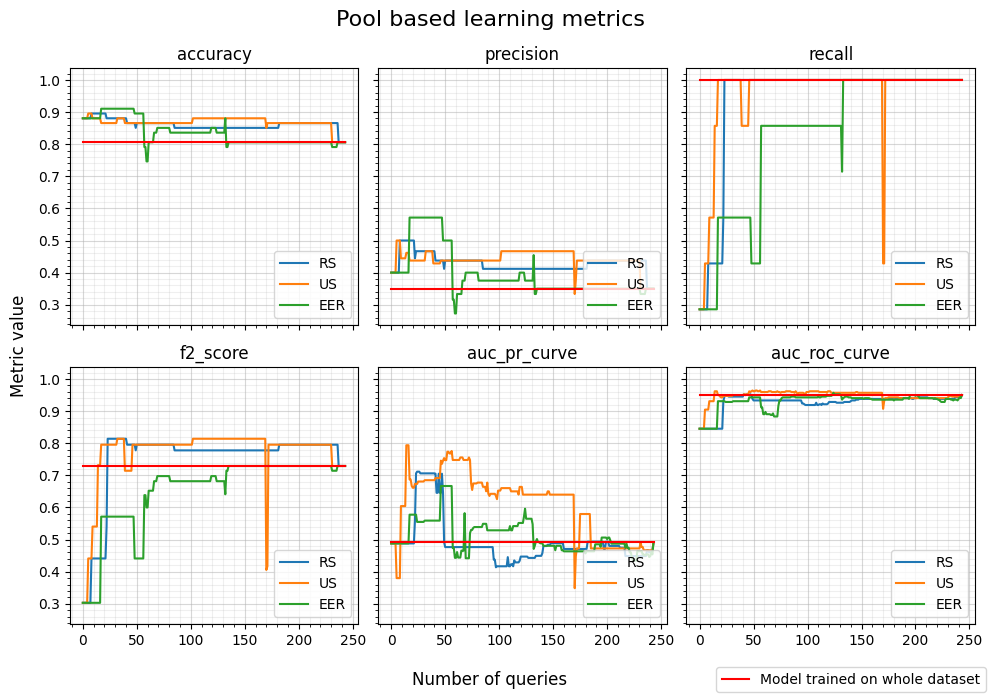

In [55]:
from matplotlib import pyplot as plt

# Fold
fold = 4 # 0-4

full_model_score = eer_results["folds"][fold]["full_model"]
if len(full_model_score) == 2:
    full_model_score = list(full_model_score["metrics"].values())
rs_performance_history = rs_results["folds"][fold]["al_metrics"]
us_performance_history = us_results["folds"][fold]["al_metrics"]
err_performance_history = eer_results["folds"][fold]["al_metrics"]

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

def plot_metrics(fig, axs, method, performance_history, full_model_score=None):

    metrics = list(zip(*[x.values() for x in performance_history]))

    for i, metric_name in enumerate(performance_history[0].keys()):
        ax = axs[int(i/3), int(i%3)]
        ax.plot(range(len(metrics[i])), metrics[i], label=method)
        if full_model_score:
            handle = ax.plot(range(len(metrics[i])), np.ones(len(metrics[i]))*full_model_score[i], "r")
        ax.set_title(metric_name)
        ax.legend(loc='lower right')
        ax.minorticks_on()
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

    if full_model_score:
        return fig, axs, handle
    else:
        return fig, axs

fig, axs = plot_metrics(fig, axs, method="RS", performance_history=rs_performance_history)
fig, axs = plot_metrics(fig, axs, method="US", performance_history=us_performance_history)
fig, axs, handle = plot_metrics(fig, axs, method="EER", performance_history=err_performance_history, full_model_score=full_model_score)

fig.suptitle("Pool based learning metrics", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')

fig.tight_layout()
fig.show()

/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_42439/1335006291.py:145: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


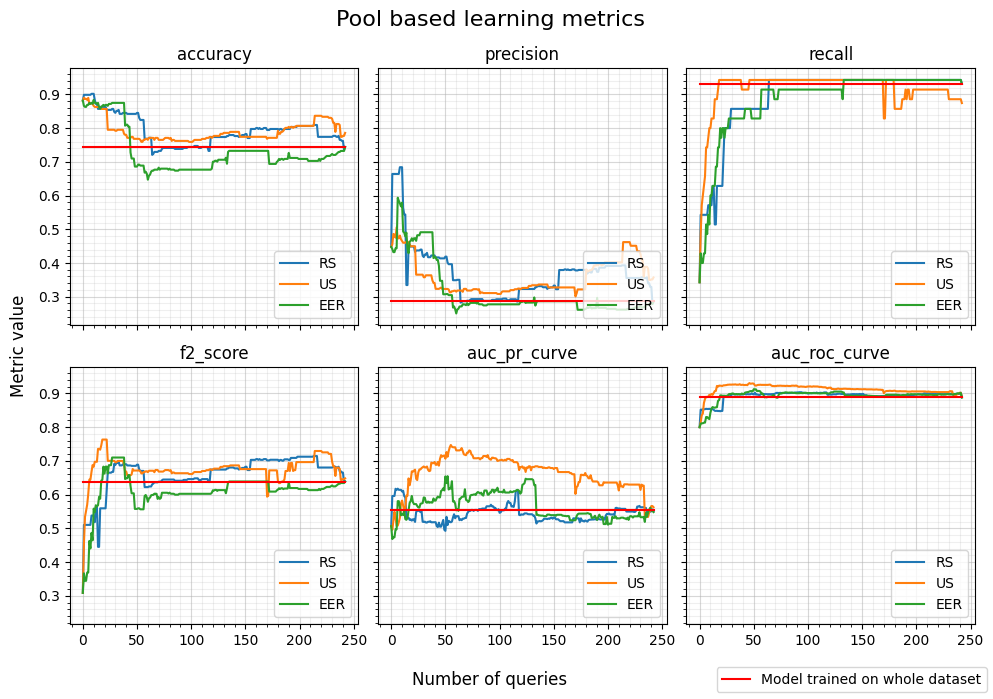

In [53]:
N_SPLITS = 5

# TODO: Get std

"""  
Input:
results = { "folds": 
    [ {
        "al_metrics":
        [{
            "accuracy": 1,
            "recall": 1,
            ...
        }, ...]
    }, ...] 
}

Output:
results = {"accuracy": [...], "precision": [...], ...}
stds = {"accuracy": [...], "precision": [...], ...}
"""

def average_al_folds(results):
    averaged_results = {}
    stds_results = {}
    averaged_metrics = []
    metrics_stds = []

    for fold in range(N_SPLITS):
        performance_history = results["folds"][fold]["al_metrics"]
        metrics = list(zip(*[x.values() for x in performance_history]))
        if len(averaged_metrics) == 0:
            averaged_metrics = metrics # [[<accuracy>...], [<precision>...], ...]
            metrics_stds = [[[query_value] for query_value in metric] for metric in metrics]
            # [[x] for y in metrics for x in y] # wrong, but for education purposes
        else:
            averaged_metrics = [[a + b for a, b in zip(sublist1, sublist2)] for sublist1, sublist2 in zip(metrics, averaged_metrics)]
            for i_metric in range(len(metrics_stds)):
                for i_query in range(len(metrics_stds[i_metric])):
                    metrics_stds[i_metric][i_query].append(metrics[i_metric][i_query])
                

    for i_metric in range(len(averaged_metrics)):
        for i_query in range(len(averaged_metrics[i_metric])):
            averaged_metrics[i_metric][i_query] /= N_SPLITS
            metrics_stds[i_metric][i_query] = np.std(metrics_stds[i_metric][i_query])

    keys = list(results["folds"][fold]["al_metrics"][0].keys())
    for i, k in enumerate(keys):
        averaged_results[k] = averaged_metrics[i]
        stds_results[k] = metrics_stds[i]
    
    return averaged_results, stds_results

"""  
Input:
results = { "folds": 
    [ {
        "al_metrics":
        [{
                "accuracy": 1,
                "recall": 1,
                ...
        }, ...]
    , 
        "full_model": 
        {
            "metrics": {
                "accuracy": 1,
                "precision": 1,
                ...
            },
            "curves": {...},
        }, 
    }, ...]
}
    
Output:
results = {"accuracy": 1, "precision": 1, ...}
stds = {"accuracy": 1, "precision": 1, ...}
"""
def average_full_model_folds(results):
    averaged_results = {}
    stds_results = {}
    averaged_metrics = []
    metrics_stds = []

    for fold in range(N_SPLITS):
        performance_history = list(results["folds"][fold]["full_model"]["metrics"].values())
        if len(averaged_metrics) == 0:
            averaged_metrics = performance_history
            metrics_stds = [[x] for x in performance_history]
        else:
            averaged_metrics = [a + b for a, b in zip(averaged_metrics, performance_history)] # [<accuracy>, <precision>, ...]
            for i in range(len(metrics_stds)):
                metrics_stds[i].append(performance_history[i])

    for i in range(len(averaged_metrics)):
        averaged_metrics[i] /= N_SPLITS
        metrics_stds[i] = np.std(metrics_stds[i])
    
    keys = list(results["folds"][fold]["full_model"]["metrics"].keys())
    for i, k in enumerate(keys):
        averaged_results[k] = averaged_metrics[i]
        stds_results[k] = metrics_stds[i]
    
    return averaged_results, stds_results


full_model_score, full_stds_results = average_full_model_folds(eer_results)
rs_performance_history, rs_stds_results = average_al_folds(rs_results)
us_performance_history, us_stds_results = average_al_folds(us_results)
err_performance_history, err_stds_results = average_al_folds(eer_results)

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

def plot_metrics(fig, axs, method, performance_history, full_model_score=None):

    for i, metric_name in enumerate(performance_history.keys()):
        ax = axs[int(i/3), int(i%3)]
        ax.plot(range(len(performance_history[metric_name])), performance_history[metric_name], label=method)
        if full_model_score:
            handle = ax.plot(range(len(performance_history[metric_name])), np.ones(len(performance_history[metric_name]))*full_model_score[metric_name], "r")
        ax.set_title(metric_name)
        ax.legend(loc='lower right')
        ax.minorticks_on()
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

    if full_model_score:
        return fig, axs, handle
    else:
        return fig, axs

fig, axs = plot_metrics(fig, axs, method="RS", performance_history=rs_performance_history)
fig, axs = plot_metrics(fig, axs, method="US", performance_history=us_performance_history)
fig, axs, handle = plot_metrics(fig, axs, method="EER", performance_history=err_performance_history, full_model_score=full_model_score)

fig.suptitle("Pool based learning metrics", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')

fig.tight_layout()
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel

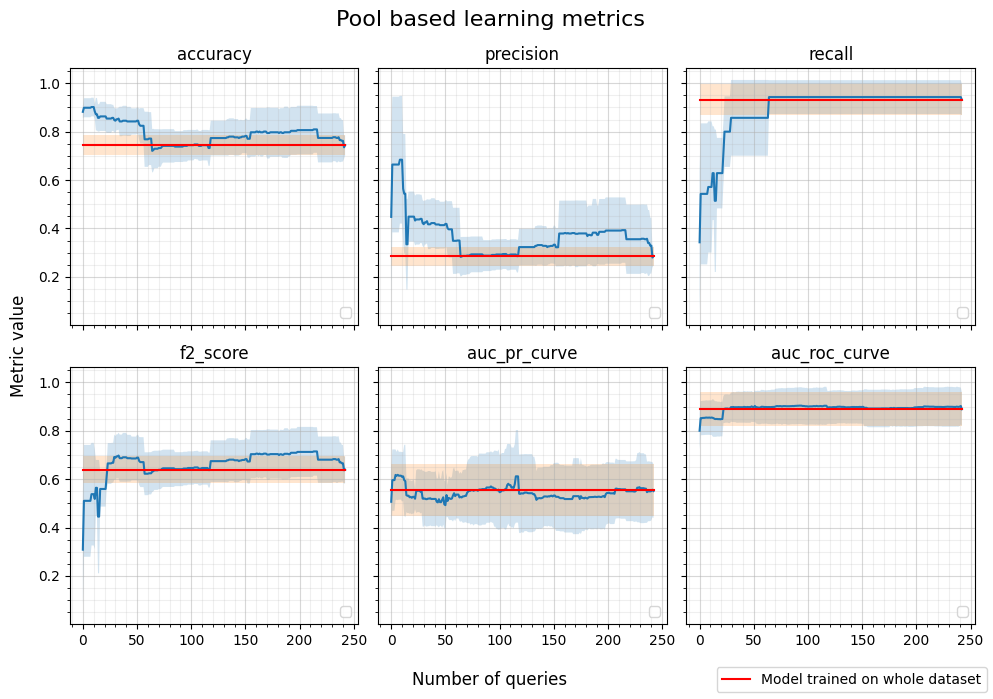

In [54]:
def plot_metrics(fig, axs, method, performance_history, stds, full_model_score=None, full_stds=None):

    for i, metric_name in enumerate(performance_history.keys()):
        ax = axs[int(i/3), int(i%3)]
        ax.plot(range(len(performance_history[metric_name])), performance_history[metric_name], label=method)
        ax.fill_between(range(len(performance_history[metric_name])), np.array(performance_history[metric_name])-np.array(stds[metric_name]), np.array(performance_history[metric_name])+np.array(stds[metric_name]), alpha=0.2)
        if full_model_score:
            handle = ax.plot(range(len(performance_history[metric_name])), np.ones(len(performance_history[metric_name]))*full_model_score[metric_name], "r")
            ax.fill_between(range(len(performance_history[metric_name])), np.ones(len(performance_history[metric_name]))*(np.array(full_model_score[metric_name])-np.array(full_stds[metric_name])), np.ones(len(performance_history[metric_name]))*(np.array(full_model_score[metric_name])+np.array(full_stds[metric_name])), alpha=0.2)
        ax.set_title(metric_name)
        ax.legend(loc='lower right')
        ax.minorticks_on()
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

    if full_model_score:
        return fig, axs, handle
    else:
        return fig, axs

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

fig, axs, handle = plot_metrics(fig, axs, method=None, performance_history=rs_performance_history, stds=rs_stds_results, full_model_score=full_model_score, full_stds=full_stds_results)

fig.suptitle("Pool based learning metrics", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')

fig.tight_layout()
fig.show()